In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import sys
import random
from os.path import join as oj
sys.path.insert(1, oj(sys.path[0], 'mnist'))

import visualize as viz
import tiling
import agglomerate
from cd import cd
from tqdm import tqdm

import torch
import mnist.mnist as dset
from mnist.mnist import pred_ims
import torch.nn.functional as F
from torch.autograd import Variable

from agglomerate import get_scores

cs_div = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']

# load the model
model = dset.Net().cuda()
model.load_state_dict(torch.load('mnist/mnist.model'))
model.eval()

# sanity check

In [2]:
# sanity check - these two should be the same
im_torch, im_orig, label = dset.get_im_and_label(0)
blob = np.zeros((1, 28, 28))
blob[:, 5:10, 15:20] = 1
print('blob shape', blob.shape, blob.dtype)
rel, irrel, scores = cd(blob, im_torch, model)

print(F.log_softmax(rel + irrel).data.cpu().numpy() - 
      model.forward(im_torch).data.cpu().numpy())

blob shape (1, 28, 28) float64
[[ 0.000000e+00  9.536743e-07  0.000000e+00  0.000000e+00 -9.536743e-07
   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00]]


/usr/local/linux/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


# look at different scores

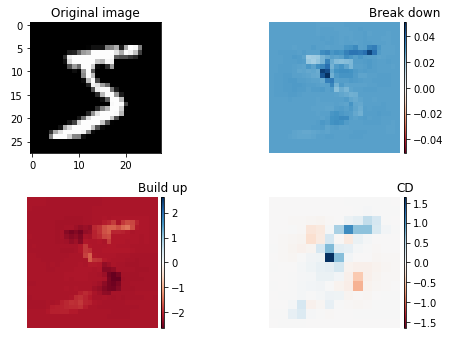

In [3]:
# pick an image
im_num = 0
im_torch, im_orig, label_num = dset.get_im_and_label(im_num)
# viz.visualize_ims_tiled(tiling.gen_tiles(im_orig, fill=np.nan, 
#                                          sweep_dim=2))


# visualize
fig = plt.figure(figsize=(7, 5), facecolor='white')
plt.subplot(2, 2, 1)
plt.imshow(im_orig, cmap='gray')
plt.title('Original image')

plt.subplot(2, 2, 2)
tiles_break = tiling.gen_tiles(im_orig, fill=0, method='break_down', sweep_dim=1)
preds_break = agglomerate.get_scores(model, method='break_down', ims=tiles_break, 
                                    im_torch=im_torch, pred_ims=pred_ims, layer='softmax')

viz.visualize_preds(preds_break, num=label_num)
plt.title('Break down')

plt.subplot(2, 2, 3)
tiles_build = tiling.gen_tiles(im_orig, fill=0, method='build_up', sweep_dim=1)
preds_build = agglomerate.get_scores(model, method='build_up', ims=tiles_build, 
                                   im_torch=im_torch, pred_ims=pred_ims, layer='softmax')
viz.visualize_preds(preds_build, num=label_num)
plt.title('Build up')

plt.subplot(2, 2, 4)
tiles_cd = tiling.gen_tiles(im_orig, fill=0, method='cd', sweep_dim=2)
scores_cd = agglomerate.get_scores(model, method='cd', ims=tiles_cd, 
                                   im_torch=im_torch)
viz.visualize_preds(scores_cd, num=label_num)
plt.title('CD')


plt.tight_layout()
plt.show()

# run agglomeration

  0%|          | 0/1 [00:00<?, ?it/s]/accounts/projects/vision/chandan/agglomerative_attention/agglomerate.py:76: RuntimeWarning: invalid value encountered in greater_equal
  im_thresh = np.logical_and(scores >= thresh, scores != 0)
100%|██████████| 1/1 [00:06<00:00,  6.30s/it]


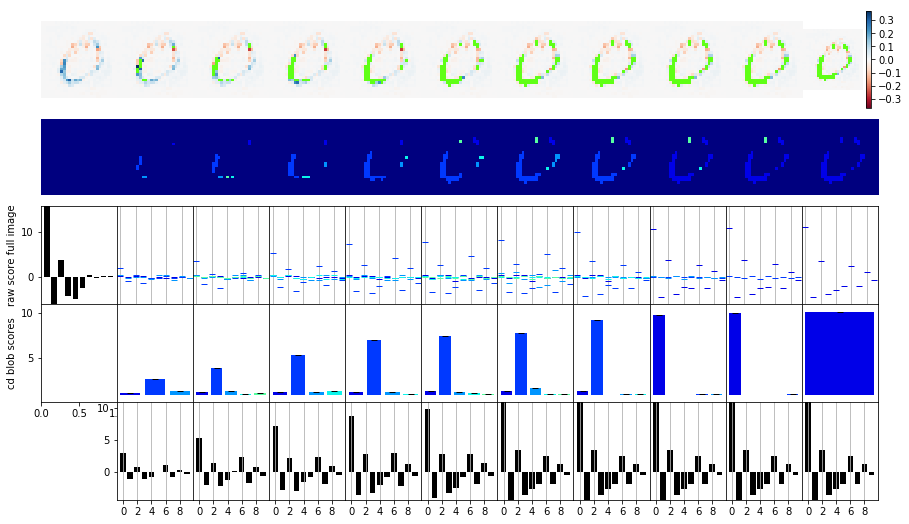

In [4]:
# hyperparams
num_iters = 6 # 8 is good
percentile_include = 99 # 0 - 100, 99 is good, 75 picks a lot
methods = ['cd'] # build_up, break_down, cd - note, broke build_up / break_down (combine_tiles)
sweep_dim = 1
im_nums = range(1, 2)
layer = 'softmax' # softmax or logit
use_abs = False

for method in methods:
    for use_abs in [False]:
        for percentile_include in [99]:
            for im_num in tqdm(im_nums):
                im_torch, im_orig, lab_num = dset.get_im_and_label(im_num)
                lists = agglomerate.agglomerate(model, pred_ims, percentile_include, 
                                                        method, sweep_dim, layer, im_orig, 
                                                        lab_num, use_abs, num_iters=num_iters, 
                                                        im_torch=im_torch, model_type='mnist')        

                # visualize
                plt.figure(figsize=(15, 9), facecolor='white')
                rows = 5
                viz.visualize_ims_list(lists['scores_list'], 
                                       cmap_new='redwhiteblue',
                                       title='Refined scores',
                                       subplot_row=0, subplot_rows=rows, colorbar=True)
                viz.visualize_ims_list(lists['comps_list'],
                                      title='blobs',
                                      subplot_row=1, subplot_rows=rows, colorbar=False)
                viz.visualize_dict_list(lists['comp_scores_raw_list'], method,
                                       subplot_row=2, subplot_rows=rows)
                viz.visualize_dict_list(lists['comp_scores_raw_list'], method, subplot_row=3, 
                                        subplot_rows=rows, lab_num=lab_num, bar_graph=True)
                viz.visualize_arr_list(lists['comp_scores_raw_combined_list'], method, 
                                       subplot_row=4, subplot_rows=rows)

                # save
                out_dir = oj('vision_results/mnist/', method)
                if not os.path.exists(out_dir):
                    os.makedirs(out_dir)
                plt.savefig(oj(out_dir, str(im_num) + '_' + method + 
                               '_perc=' + str(percentile_include) +
                               '_useabs=' + str(use_abs) + '.png'))

# mturk viz

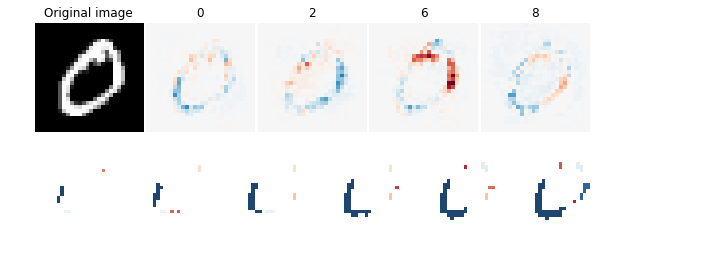

In [31]:
# visualize
plt.figure(figsize=(12, 4), facecolor='white')
mturk=True

rows = 2     
num_ims = len(lists['scores_list'])

# original plots
ind, labs = viz.visualize_original_preds_mnist(im_orig, lab_num, 
                                         lists['comp_scores_raw_list'], lists['scores_orig_raw'],
                                         subplot_rows=rows, dset=dset, mturk=mturk)

# comp plots
num_ims = lists['num_before_final']
# viz.visualize_ims_list(np.copy(lists['comps_list']), title='', subplot_row=1, subplot_rows=rows, 
#                        colorbar=False, im_orig=im_orig, plot_overlay=True, 
#                        mturk=mturk, num_ims=lists['num_before_final'], 
#                        comp_scores_raw=lists['comp_scores_raw_list'], lab_num_correct=lab_pred) # mturk stuff
viz.visualize_ims_list(lists['comps_list'], title='',  subplot_row=1, subplot_rows=rows, colorbar=False,
                       num_ims=lists['num_before_final'], im_orig=im_orig, plot_overlay=True,
                       mturk=True, comp_scores_raw=lists['comp_scores_raw_list'], lab_num_correct=lab_num, mnist=True, skip_first=True)

# save
out_dir = oj('vision_results/mnist', method)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
plt.savefig(oj(out_dir, str(im_num) + '_' + method + '_mturk.png'))